In [1]:
import cv2
import numpy as np
import numpy.typing as npt
from pathlib import Path
from skimage import color as skcolor
import matplotlib.pyplot as plt

In [2]:
def normalize_img(
    img: npt.NDArray[np.float64], rimg: npt.NDArray[np.float64]
) -> npt.NDArray[np.float64]:
    """normalize an image according to a reference image"""
    norm_img: npt.NDArray[np.float64] = np.zeros_like(img, dtype=np.float64)
    for c in range(3):
        # norm_img[:, :, c] = img[:, :, c] / rimg[:, :, c]
        norm_img[:, :, c] = np.divide(img[:, :, c], rimg[:, :, c])
        norm_img[:, :, c] = np.nan_to_num(norm_img[:, :, c], nan=0)

    norm_img = np.clip(norm_img, 0, 1)
    return norm_img

/tmp/ipykernel_22166/2577486741.py:8: RuntimeWarning: invalid value encountered in divide
  norm_img[:, :, c] = np.divide(img[:, :, c], rimg[:, :, c])


[[ 59  29 220]
 [ 82  14 251]
 [ 73  18 238]]


IndexError: index 97 is out of bounds for axis 0 with size 97

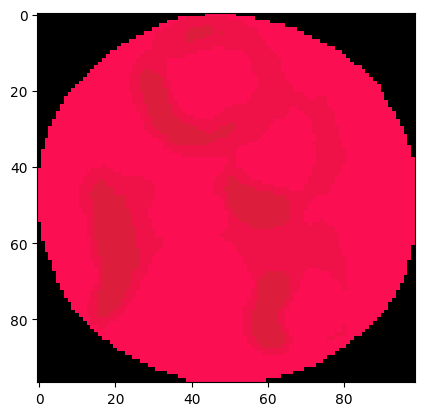

In [3]:
src_dir = './img'
folder = Path(src_dir)

# files
files = folder.glob('*_ref.png')

for i in list(files):
    
    image_path = str(i).replace('_ref',"")
    #print(image_path)
    # img
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    # Reference image    
    rimg = cv2.cvtColor(cv2.imread(str(i)), cv2.COLOR_BGR2RGB)
    
    # Normalizacion
    norm_img = normalize_img(img,rimg)
    
    # rgbtolab
    lab_image = skcolor.rgb2lab(norm_img)
    lch_image = skcolor.lab2lch(lab_image)
    
    # Plotting
    #plt.imshow(norm_img)
   # plt.imshow(lab_image)
   # plt.imshow(lch_image)
    
    # Redimensionar para clustering
    original_shape = lab_image.shape
    lab_image = lab_image.reshape((-1,3))
    lch_image = lch_image.reshape((-1,3))
    
    lab_image = np.float32(lab_image)
    lch_image = np.float32(lch_image)
    
    # Clustering k-means
    stop_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1.0)
    number_of_attempts = 30
    centroid_initialization_strategy = cv2.KMEANS_RANDOM_CENTERS
    # Number of clusters
    K = 4
    _, labels, centers = cv2.kmeans(lab_image, K, None, stop_criteria, number_of_attempts, centroid_initialization_strategy)
        
    centers = np.uint8(centers)
    
    segmented_data = centers[labels.flatten()]
    
    #print(labels.flatten())
    
    segmented_image = segmented_data.reshape(original_shape)
    
    plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
    #plt.axis('off') 
    
    # Quitar los ceros
    centers = centers[~np.all(centers == 0, axis=1)]
    imagenes = []
    npixels = []
    
    print(centers)
    
    for k in range(centers.shape[0]):
        
        result_image = np.zeros_like(lab_image)
        for f in range(lab_image.shape[0]):
            if np.allclose(segmented_image[f],centers[k]):
                result_image[f] = lab_image[f]
                
        npixels.append(np.count_nonzero(result_image))
        imagenes.append(result_image)
    
    print(npixels)
    indices_ordenados = sorted(range(len(npixels)), key=lambda ix: npixels[ix])    

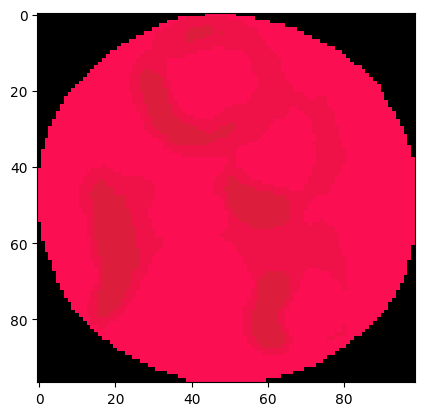

In [4]:
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)) 